## LCT/SRW Drift Comparison

In [1]:
import numpy as np
import time as tm
import math
import scipy.constants as const
from pykern import pkcli
from pykern.pkcollections import PKDict

import srwlib
from srwlib import srwl
from srwlib import *

from rsmath import lct as rslct

from rslaser.pulse import pulse as pulse
from rslaser.utils import srwl_uti_data as srwutil
# import sys
#     # caution: path[0] is reserved for script path (or '' in REPL)
# sys.path.insert(1, '/../../rslaser/utils')


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# 3D plotting
import plotly.graph_objects as go

# Specify which plots are desired
RENDER_2D_PLOTS = True
RENDER_3D_PLOTS = True

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
# plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
# plt.style.use('Solarize_Light2')
hfontLarge = {'fontname':'Latin Modern Roman', 'size' : 24, 'weight' : 'bold'}
hfontMed = {'fontname':'Latin Modern Roman', 'size' : 15}

#### define relevant LCT functions

In [2]:
def apply_lct_2d_sep(MX_lct, MY_lct, in_signal):
    """
    Apply LCT[M_lct] to a given input signal, and return the result.
    In this case, the 4x4 matrix M_lct is assumed separable and defined
    by the pair of 2x2 matrices MX_lct and MY_lct. In addition, the
    input signal is taken to have the form ( dX, dY, signal_array ),
    where dX and dY denote the sample intervals along the rows and
    columns respectively of the given 2D signal_array.

    Given a pair of symplectic 2x2 ABCD matrices that define an
    uncoupled LCT in two dimensions, apply LCT[MX_lct] to each row,
    and then LCT[MY_lct] to each column.

    The algorithm implemented here is that given by Koç, et al.
    in IEEE Trans. Signal Proc. 56(6):2383--2394, June 2008.

    Arguments:
    MX_lct -- symplectic 2x2 matrix that describes the desired LCT
    MY_lct -- symplectic 2x2 matrix that describes the desired LCT
    in_signal -- the signal to transform, [ dX, dY, signal_array], where
                 dX and dY denote the sample intervals of the given
                 signal along its two axes

    Return the transformed signal in the form [ dY, LCT[M_lct](signal)].
    """
    # extract the pieces
    dX, dY, signal_array = in_signal

    # apply LCT[MX_lct] to each row
    lct_x = [ rslct.apply_lct(MX_lct, (dX, sig_x)) for sig_x in signal_array  ]
    dX_out = lct_x[0][0]

    # apply LCT[MY_lct] to each column
    signal_array = np.asarray([ s[-1] for s in lct_x ]).T
    lct_y = [ rslct.apply_lct(MY_lct, (dY, sig_y)) for sig_y in signal_array ]
    dY_out = lct_y[0][0]

    signal_array = np.asarray([ s[-1] for s in lct_y ]).T
    return (dX_out, dY_out, signal_array)

#### create Gsn source with createGsnSrcSRW()

In [3]:
#Create Gaussian wavefront
dist_waist = 10 # 50    # distance from waist [m]
sigx = 1e-3    # horizontal beam size at waist [m]
sigy = 1e-3    # vertical beam size at waist [m]
num_sig = 24
nx_init = 300
ny_init = 300
pulseE = .001
poltype = 1
phE = 0.124 # Energy in eV corresponding to 10 micron wavelength
# phE = 9000 # Energy in eV corresponding to 10 micron wavelength

##Convert energy to wavelength
hc_ev_um = 1.23984198   # hc [eV*um]
phLambda = hc_ev_um / phE * 1e-6 # wavelength corresponding to phE in meters
print("Wavelength corresponding to %g keV: %g microns" %(phE * 1e-3, phLambda / 1e-6))

z_R_x = 4 * np.pi * sigx**2 / phLambda    # horizontal Rayleigh range [m]
z_R_y = 4 * np.pi * sigy**2 / phLambda    # verrtical Rayleigh range [m]
print(r'z_{R_x} = %g [m], z_{R_y} = %g [m]' %(z_R_x, z_R_y))

# constConvRad = 1.23984186e-06/(4*3.1415926536)  ##conversion from energy to 1/wavelength
# rmsAngDiv = constConvRad/(phE*sigrW)
# print("RMS beam divergence at waist: %s radians" %(rmsAngDiv))
mx = 0
my = 0

Wavelength corresponding to 0.000124 keV: 9.99873 microns
z_{R_x} = 1.2568 [m], z_{R_y} = 1.2568 [m]


In [4]:
#create a Gaussian wavefront in SRW
t0 = time.time()
# createGsnSrcSRW02(sigx, sigy, posWaist, pulseE, poltype, nx = 400, ny = 400, phE=10e3, mx = 0, my = 0)
wfr0 = srwutil.createGsnSrcSRW(sigx, sigy, num_sig, dist_waist, pulseE, poltype, nx_init, ny_init, phE, mx, my)
# wfr0 = wavefront.createGsnSrcSRW(sigrW,propLen,pulseE,poltype,phE,sampFact,mx,my)
t1 = time.time()
printmd("Initial Gsn wavefront calc time: %4.3f seconds" % ((t1 - t0)))    
print("Initial wavefront calculated on a grid of %d x %d points" %(wfr0.mesh.nx,wfr0.mesh.ny))



Initial Gsn wavefront calc time: 0.055 seconds

Initial wavefront calculated on a grid of 300 x 300 points


#### extract intensity, phase, real, and imaginary fields from Gsn wavefront

In [5]:
int0, int0_mesh = srwutil.calc_int_from_wfr(wfr0, _pol=0, _int_type=0, _det=None, _fname='', _pr=True)
phase0, phase0_mesh = srwutil.calc_int_from_wfr(wfr0, _pol=0, _int_type=4, _det=None, _fname='', _pr=True)
re0, re0_mesh = srwutil.calc_int_from_wfr(wfr0, _pol=0, _int_type=5, _det=None, _fname='', _pr=True)
im0, im0_mesh = srwutil.calc_int_from_wfr(wfr0, _pol=0, _int_type=6, _det=None, _fname='', _pr=True)

Extracting intensity and saving it to a file ... completed (lasted 0.01 s)
Extracting intensity and saving it to a file ... completed (lasted 0.01 s)
Extracting intensity and saving it to a file ... completed (lasted 0.01 s)
Extracting intensity and saving it to a file ... completed (lasted 0.01 s)


In [6]:
print(np.shape(re0))
print(np.shape(im0))

int0_2d = np.array(int0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
phase0_2d = np.array(phase0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
re0_2d = np.array(re0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
im0_2d = np.array(im0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')

(90000,)
(90000,)


In [7]:
print('Size of initial wavefront data array (coordinate):',np.shape(int0_2d))
xvalsf02=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
yvalsf02=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)

Size of initial wavefront data array (coordinate): (300, 300)


Text(0.5, 1.0, 'Initial Wavefront Intensity')

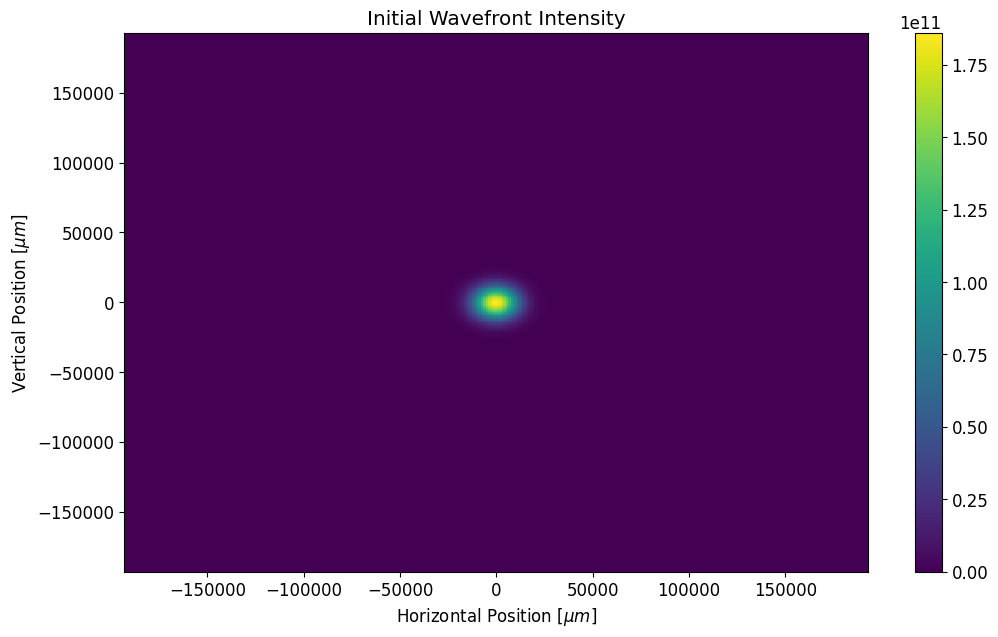

In [8]:
# plot initial intensity
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), int0_2d, cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap = Beach, shading='auto')
plt.colorbar()

# ax.set_ylim(-3000, 3000)
# ax.set_xlim(-3000, 3000)
ax.set_ylabel(r'Vertical Position [$\mu m$]')
ax.set_xlabel(r'Horizontal Position [$\mu m$]')
ax.set_title('Initial Wavefront Intensity')

Text(0.5, 1.0, 'Initial Wavefront Phase')

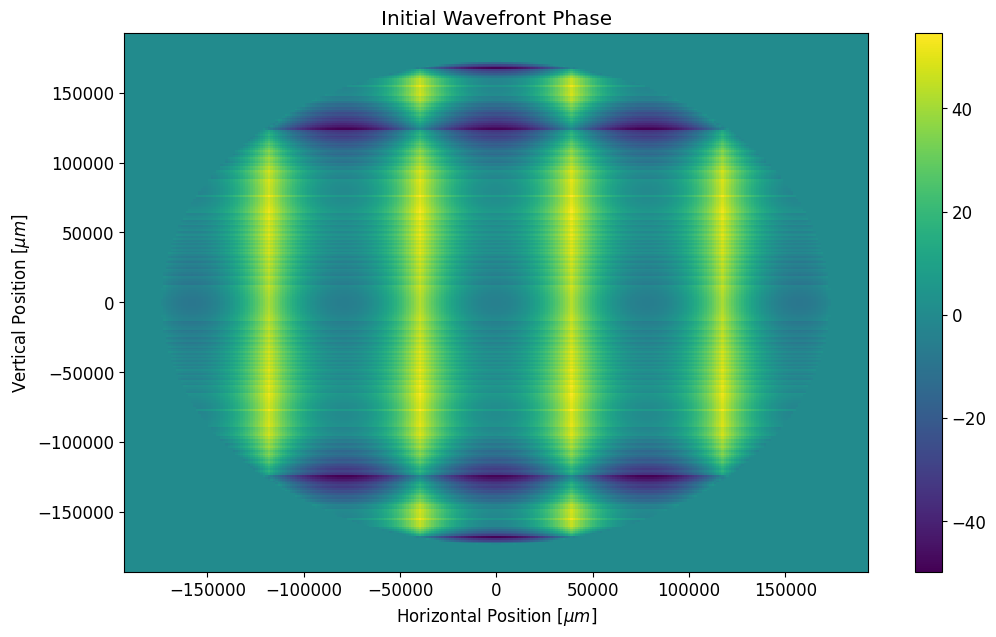

In [9]:
# plot initial phase
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), np.unwrap(phase0_2d), cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap = Beach, shading='auto')
plt.colorbar()

# ax.set_ylim(-45, 45)
# ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$\mu m$]')
ax.set_xlabel(r'Horizontal Position [$\mu m$]')
ax.set_title('Initial Wavefront Phase')

In [10]:
# # plot the 3D phase information
# if RENDER_3D_PLOTS:
#     fig = go.Figure(data=[go.Surface(x=xvalsf02, y=yvalsf02, z=phase0_2d)])
#     fig.update_traces(contours_z=dict(show=True, usecolormap=True,
#         highlightcolor="limegreen", project_z=True)
#     )
#     fig.update_layout(title='Wavefront phases before the crystal', autosize=False,
#         width=800, height=700, margin=dict(l=65, r=50, b=65, t=90)
#     )
#     fig.show()

In [11]:
Etot0_2d = re0_2d + 1j*im0_2d

jx_cen = np.floor(nx_init / 2).astype(int)
jy_cen = np.floor(ny_init / 2).astype(int)
print(jx_cen, jy_cen)

phase0 = Etot0_2d[jx_cen, jy_cen] / np.abs(Etot0_2d[jx_cen, jy_cen])
print(phase0)

Etot0_2d_pc = Etot0_2d / phase0

150 150
(0.09922874+0.9950646j)


Text(0.5, 1.0, 'Initial Wavefront Re(E)')

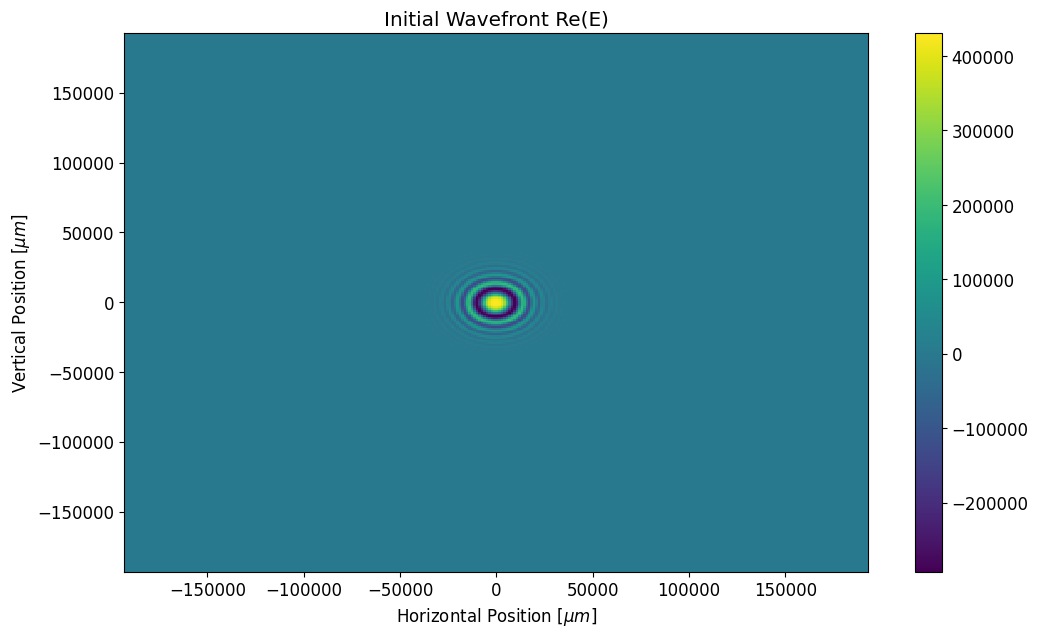

In [12]:
# plot initial Re(E)
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), np.real(Etot0_2d_pc), cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap = Beach, shading='auto')
plt.colorbar()

# ax.set_ylim(-45, 45)
# ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$\mu m$]')
ax.set_xlabel(r'Horizontal Position [$\mu m$]')
ax.set_title('Initial Wavefront Re(E)')

Text(0.5, 1.0, 'Initial Wavefront Im(E)')

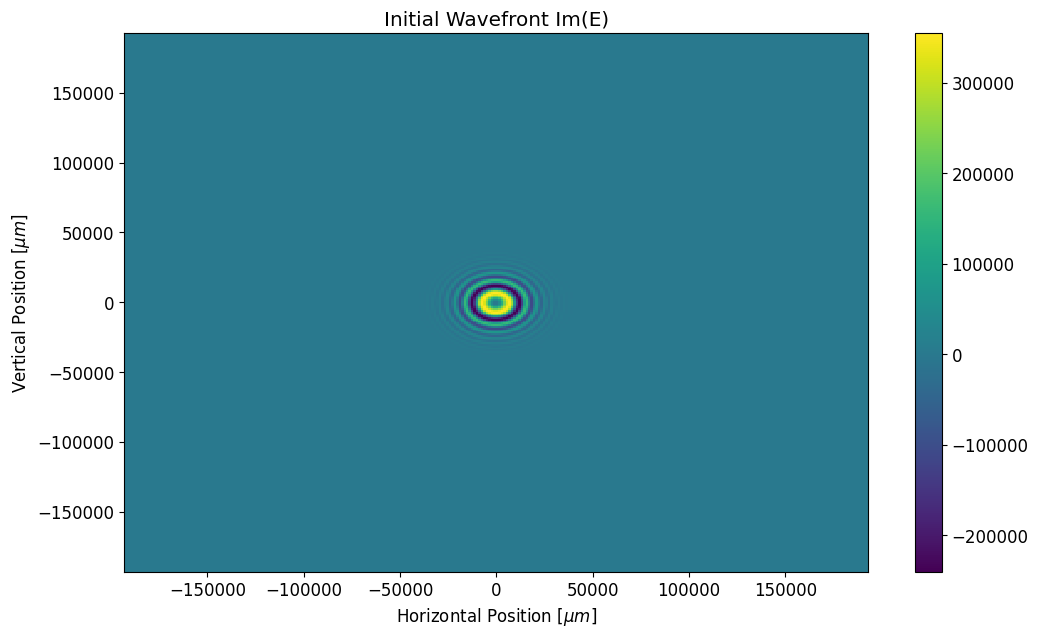

In [13]:
# plot initial Im(E)
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvalsf02,1e6), np.multiply(yvalsf02,1e6), np.imag(Etot0_2d_pc), cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap = Beach, shading='auto')
plt.colorbar()

# ax.set_ylim(-45, 45)
# ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$\mu m$]')
ax.set_xlabel(r'Horizontal Position [$\mu m$]')
ax.set_title('Initial Wavefront Im(E)')

### propagate Gsn field via LCT

In [14]:
# construct drift matrix
L = 5.0 # drift length (m)
# wavelength = 1e-9 #wavelength (m)
M_drift_lam = np.array([[ 1,  L*phLambda  ],
                     [ 0, 1 ]])
print(rslct.lct_decomposition(M_drift_lam))

[['SCL', -1.0], ['LCFT', 0], ['RSMP', 2.0], ['CM', 4.9993628225806446e-05], ['LCFT', 0], ['RSMP', 0.5000249968141129], ['CM', 0.0]]


In [15]:
dX = xvalsf02[1] - xvalsf02[0]                       # horizontal spacing [mm]
# xv = rslct.lct_abscissae(nx_init, dX, ishift = False)      # x values array
dY = yvalsf02[1] - yvalsf02[0]                       # vertical spacing [mm]
# yv = rslct.lct_abscissae(ny_init, dY, ishift = False)      # y values array

In [16]:
# define input signal
in_signal_2d = (dX, dY, Etot0_2d_pc)

In [17]:
# calculate 2D LCT
t0 = time.time()
dX_out, dY_out, out_signal_2d = apply_lct_2d_sep(M_drift_lam, M_drift_lam, in_signal_2d)
t1 = time.time()
time_lct = t1 - t0  # LCT propagation time [s]
printmd("LCT propagation calc time: %4.3f seconds" % ((time_lct)))

LCT propagation calc time: 0.505 seconds

In [18]:
# calculate x and y mesh arrays for transformed wavefront
hx = dX_out 
hy = dY_out 
sig_arr = out_signal_2d
ny, nx = np.shape(sig_arr)
local_xv = rslct.lct_abscissae(nx, hx)
local_yv = rslct.lct_abscissae(ny, hy)

# calculate phase constant
jx_cen_lct_prop = np.floor(nx / 2).astype(int)
jy_cen_lct_prop = np.floor(ny / 2).astype(int)
print(jx_cen_lct_prop, jy_cen_lct_prop)

phase0_lct_prop = sig_arr[jx_cen_lct_prop, jy_cen_lct_prop] / np.abs(sig_arr[jx_cen_lct_prop, jy_cen_lct_prop])
print(phase0_lct_prop)

# calculate phase corrected LCT-propagated E field
sig_arr_pc = sig_arr / phase0_lct_prop


# calculate propagated intensity, Re(E), Im(E) distribution from complex LCT output
int_final_lct = np.square(np.abs(sig_arr))
efield_re_final_lct = np.real(sig_arr_pc)
efield_im_final_lct = np.imag(sig_arr_pc)

150 150
(0.9987493646416021-0.04999706619388967j)


Initial wavefront mesh: 300 x 300

LCT propagated wavefront mesh: 301 x 301

Text(0.5, 1.0, 'Final (LCT) Wavefront Intensity')

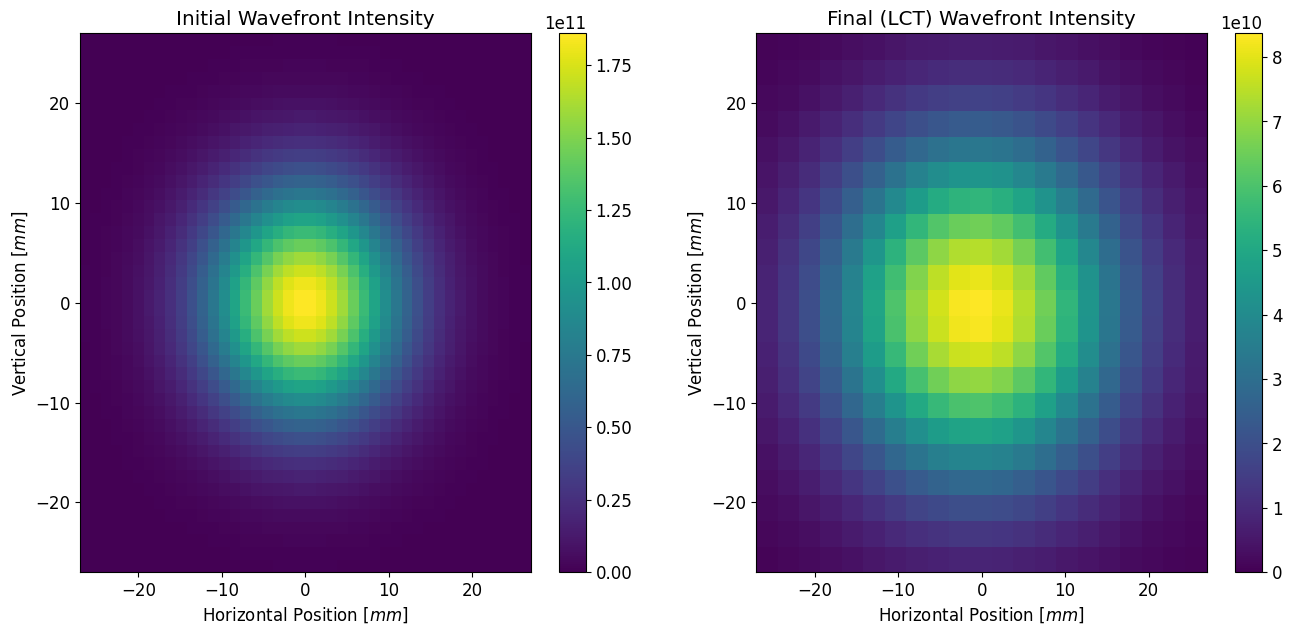

In [19]:
# plot initial and final (LCT propagated) intensities

printmd('Initial wavefront mesh: %d x %d' %(nx_init, nx_init))
printmd('LCT propagated wavefront mesh: %d x %d' %(np.size(sig_arr[0,:]), (np.size(sig_arr[:,0]))))

plt_x_ran = 54   # horizontal plot range [mm]
plt_y_ran = 54   # vertical plot range [mm]

fig = plt.figure(figsize=(16,7))

ax = plt.subplot(1, 2, 1)

plt.pcolormesh(np.multiply(xvalsf02,1e3), np.multiply(yvalsf02,1e3), int0_2d, cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap = Beach, shading='auto')
plt.colorbar()
ax.set_ylim(-plt_y_ran / 2, plt_y_ran / 2)
ax.set_xlim(-plt_x_ran / 2, plt_x_ran / 2)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Initial Wavefront Intensity')


ax = plt.subplot(1, 2, 2)
plt.pcolormesh(np.multiply(local_xv,1e3), np.multiply(local_yv,1e3), int_final_lct, cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap = Beach, shading='auto')
plt.colorbar()
ax.set_ylim(-plt_y_ran / 2, plt_y_ran / 2)
ax.set_xlim(-plt_x_ran / 2, plt_x_ran / 2)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Final (LCT) Wavefront Intensity')

### propagate Gsn field via SRW

In [20]:
wfr1 = deepcopy(wfr0)

In [21]:
# construct drift beamline
optDriftW = SRWLOptD(L)
propagParDrift = [0, 0, 1., 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
#[ 0]: Auto-Resize (1) or not (0) Before propagation
#[ 1]: Auto-Resize (1) or not (0) After propagation
#[ 2]: Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[ 3]: Allow (1) or not (0) for semi-analytical treatment of the quadratic (leading) phase terms at the propagation - 2: quad term (special), 3: from waist, 4: to waist
#[ 4]: Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[ 5]: Horizontal Range modification factor at Resizing (1. means no modification)
#[ 6]: Horizontal Resolution modification factor at Resizing
#[ 7]: Vertical Range modification factor at Resizing
#[ 8]: Vertical Resolution modification factor at Resizing
#[ 9]: Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#[12]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Horizontal Coordinate
#[13]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Vertical Coordinate
#[14]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Longitudinal Coordinate
#[15]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Horizontal Coordinate
#[16]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Vertical Coordinate
optBLW = SRWLOptC([optDriftW],[propagParDrift])

In [22]:
# propagate wavefront via SRW
t0 = time.time()
srwl.PropagElecField(wfr1, optBLW)
t1 = time.time()
time_srw = t1 - t0  # SRW propagation time [s]
printmd("SRW propagation calc time: %4.3f seconds" % ((time_srw)))

SRW propagation calc time: 0.013 seconds

In [23]:
# extract SRW propagated intensity
arIf = srwlib.array('f', [0]*wfr1.mesh.nx*wfr1.mesh.ny)                  # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arIf, wfr1, 6, 0, 3, wfr1.mesh.eStart, 0, 0)   # extracts intensity
efield_re_srw_fin = srwlib.array('f', [0]*wfr1.mesh.nx*wfr1.mesh.ny)                  # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(efield_re_srw_fin, wfr1, 6, 5, 3, wfr1.mesh.eStart, 0, 0)   # extracts intensity
efield_im_srw_fin = srwlib.array('f', [0]*wfr1.mesh.nx*wfr1.mesh.ny)                  # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(efield_im_srw_fin, wfr1, 6, 6, 3, wfr1.mesh.eStart, 0, 0)   # extracts intensity

# reshaping electric field data from flat to 2D array
arIf2D = np.array(arIf).reshape((wfr1.mesh.nx, wfr1.mesh.ny), order='C')
efield_re_srw_fin_2d = np.array(efield_re_srw_fin).reshape((wfr1.mesh.nx, wfr1.mesh.ny), order='C')
efield_im_srw_fin_2d = np.array(efield_im_srw_fin).reshape((wfr1.mesh.nx, wfr1.mesh.ny), order='C')

# calculate phase constant for SRW results
jx_cen_srw_prop = np.floor(wfr1.mesh.nx / 2).astype(int)
jy_cen_srw_prop = np.floor(wfr1.mesh.ny / 2).astype(int)
print(jx_cen_srw_prop, jy_cen_srw_prop)

efield_tot_srw = efield_re_srw_fin_2d + 1j * efield_im_srw_fin_2d

phase0_srw_prop = efield_tot_srw[jx_cen_srw_prop, jy_cen_srw_prop] / np.abs(efield_tot_srw[jx_cen_srw_prop, jy_cen_srw_prop])
print(phase0_srw_prop)

# calculate phase corrected SRW-propagated E field
efield_tot_srw_pc = efield_tot_srw / phase0_srw_prop

# extract real and imaginary components of phase-corrected E field
efield_srw_pc_re = np.real(efield_tot_srw_pc)
efield_srw_pc_im = np.imag(efield_tot_srw_pc)

# create xvals and yvals for propagated wavefront array
xvals_prop=np.linspace(wfr1.mesh.xStart,wfr1.mesh.xFin,wfr1.mesh.nx)
yvals_prop=np.linspace(wfr1.mesh.yStart,wfr1.mesh.yFin,wfr1.mesh.ny)

150 150
(0.14868066+0.9888852j)


Initial wavefront mesh: 300 x 300

SRW propagated wavefront mesh: 300 x 300

Text(0.5, 1.0, 'Final (SRW) Wavefront Intensity')

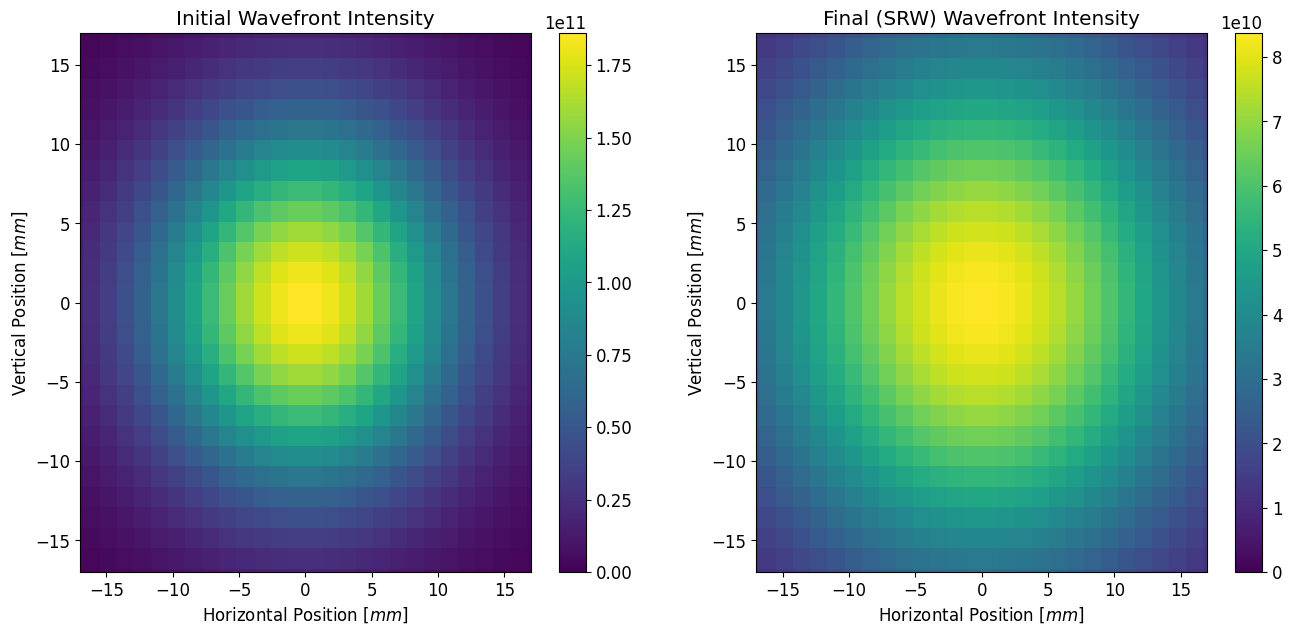

In [24]:
# plot initial and final (SRW propagated) intensities

printmd('Initial wavefront mesh: %d x %d' %(nx_init, nx_init))
printmd('SRW propagated wavefront mesh: %d x %d' %(wfr1.mesh.nx, wfr1.mesh.ny))


plt_x_ran = 34   # horizontal plot range [mm]
plt_y_ran = 34   # vertical plot range [mm]

fig = plt.figure(figsize=(16,7))

ax = plt.subplot(1, 2, 1)

plt.pcolormesh(np.multiply(xvalsf02,1e3), np.multiply(yvalsf02,1e3), int0_2d, cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap = Beach, shading='auto')
plt.colorbar()
ax.set_ylim(-plt_y_ran / 2, plt_y_ran / 2)
ax.set_xlim(-plt_x_ran / 2, plt_x_ran / 2)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Initial Wavefront Intensity')


ax = plt.subplot(1, 2, 2)
plt.pcolormesh(np.multiply(xvals_prop,1e3), np.multiply(yvals_prop,1e3), arIf2D, cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap = Beach, shading='auto')
plt.colorbar()
ax.set_ylim(-plt_y_ran / 2, plt_y_ran / 2)
ax.set_xlim(-plt_x_ran / 2, plt_x_ran / 2)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Final (SRW) Wavefront Intensity')

### Compare LCT and SRW

In [25]:
printmd('Initial wavefront mesh: %d x %d' %(nx_init, nx_init))

printmd('LCT propagated wavefront mesh: %d x %d' %(np.size(sig_arr[0,:]), (np.size(sig_arr[:,0]))))
printmd('LCT propagation time: %g s' %(time_lct))

printmd('SRW propagated wavefront mesh: %d x %d' %(wfr1.mesh.nx, wfr1.mesh.ny))
printmd('SRW propagation time: %g s' %(time_srw))

Initial wavefront mesh: 300 x 300

LCT propagated wavefront mesh: 301 x 301

LCT propagation time: 0.505005 s

SRW propagated wavefront mesh: 300 x 300

SRW propagation time: 0.0130334 s

In [26]:
jx_cen_prop_lct = np.floor(nx / 2).astype(int)
jy_cen_prop_lct = np.floor(ny / 2).astype(int)
print(jx_cen_prop_lct, jy_cen_prop_lct)

jx_cen_prop_srw = np.floor(np.size(sig_arr[:,0]) / 2).astype(int)
jy_cen_prop_srw = np.floor(np.size(sig_arr[0,:]) / 2).astype(int)
print(jx_cen_prop_srw, jy_cen_prop_srw)

150 150
150 150


In [27]:
int_slice_hor_lct = int_final_lct[:, jy_cen_prop_lct]
int_slice_hor_srw = arIf2D[:, jy_cen_prop_srw]
print(np.shape(int_slice_hor_lct))

(301,)


Initial wavefront mesh: 300 x 300

LCT propagated wavefront mesh: 301 x 301

LCT propagation time: 0.505005 s

SRW propagated wavefront mesh: 300 x 300

SRW propagation time: 0.0130334 s

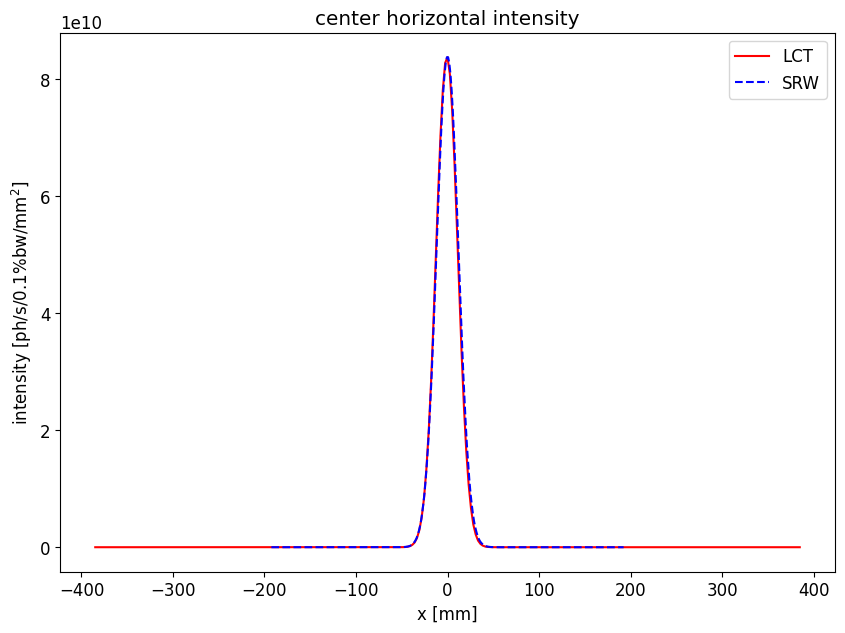

In [28]:
fig = plt.figure(figsize = (10, 7))
ax = fig.gca()

ax.plot(np.multiply(local_xv,1e3), int_slice_hor_lct, 'r-', label = r'LCT')
ax.plot(np.multiply(xvals_prop,1e3), int_slice_hor_srw, 'b--',  label = r'SRW')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
# plt.xlim(0,350)
# plt.ylim(0,100)
plt.title('center horizontal intensity')
plt.xlabel('x [mm]')
plt.ylabel(r'intensity [ph/s/0.1%bw/mm$^2$]')
plt.legend()

printmd('Initial wavefront mesh: %d x %d' %(nx_init, nx_init))

printmd('LCT propagated wavefront mesh: %d x %d' %(np.size(sig_arr[0,:]), (np.size(sig_arr[:,0]))))
printmd('LCT propagation time: %g s' %(time_lct))

printmd('SRW propagated wavefront mesh: %d x %d' %(wfr1.mesh.nx, wfr1.mesh.ny))
printmd('SRW propagation time: %g s' %(time_srw))

In [29]:
print('SRW dx: %g [mm]' %(1e3*(xvals_prop[1] - xvals_prop[0])))
print('LCT dx: %g [mm]' %(1e3*(local_xv[1] - local_xv[0])))

SRW dx: 1.28738 [mm]
LCT dx: 2.56621 [mm]


#### compare integrated energies

In [30]:
# integrate initial intensity
dx_init = xvalsf02[1] - xvalsf02[0]
dy_init = yvalsf02[1] - yvalsf02[0]
intx_init = np.sum(int0_2d, axis=1)
intxy_init = np.sum(intx_init) * dx_init * dy_init
print(intxy_init / 1e6)

75.65958386751984


In [31]:
# integrate final srw intensity
dx_srw_fin = xvals_prop[1] - xvals_prop[0]
dy_srw_fin = yvals_prop[1] - yvals_prop[0]
intx_srw_fin = np.sum(arIf2D, axis=1)
intxy_srw_fin = np.sum(intx_srw_fin) * dx_srw_fin * dy_srw_fin
print(intxy_srw_fin / 1e6)

75.65959081897513


In [32]:
# integrate final lct intensity
intx_lct_fin = np.sum(int_final_lct, axis=1)
intxy_lct_fin = np.sum(intx_lct_fin) * hx * hy
print(intxy_lct_fin / 1e6)

72.78031073647071


#### compare real and imaginary fields

Initial wavefront mesh: 300 x 300

SRW propagated wavefront mesh: 300 x 300

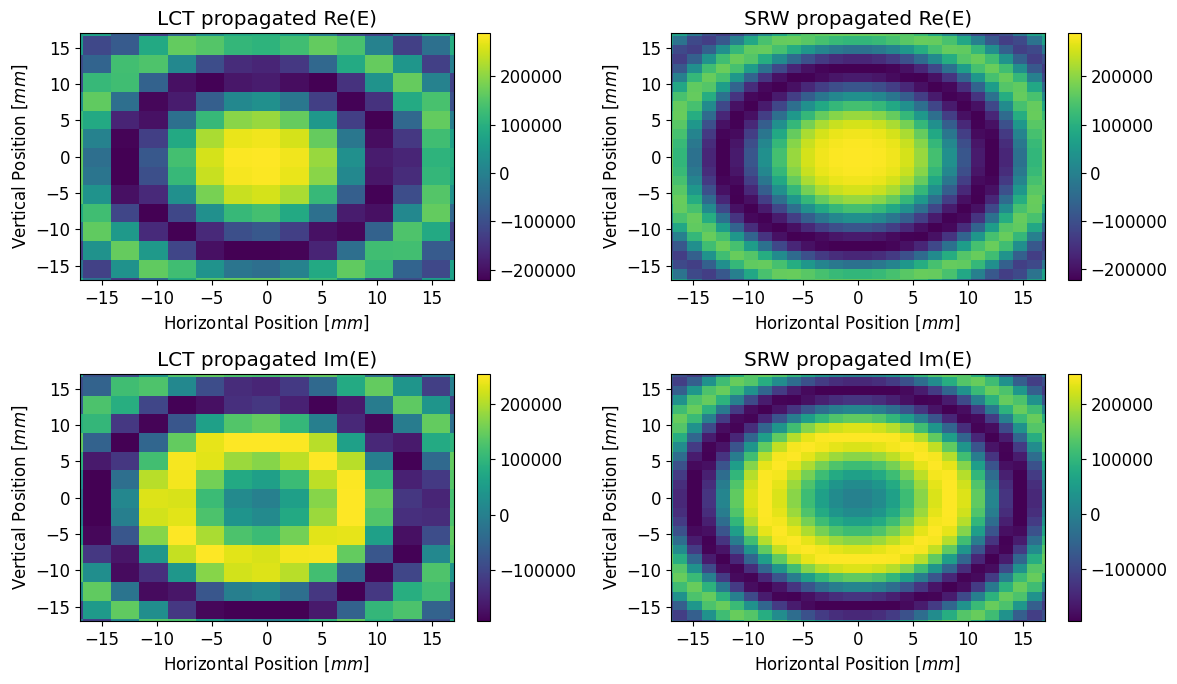

In [33]:
# plot initial and final (SRW propagated) intensities

printmd('Initial wavefront mesh: %d x %d' %(nx_init, nx_init))
printmd('SRW propagated wavefront mesh: %d x %d' %(wfr1.mesh.nx, wfr1.mesh.ny))


plt_x_ran = 34   # horizontal plot range [mm]
plt_y_ran = 34   # vertical plot range [mm]

fig = plt.figure(figsize=(12,7))

ax = plt.subplot(2, 2, 1)
plt.pcolormesh(np.multiply(local_xv,1e3), np.multiply(local_yv,1e3), efield_re_final_lct, cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap = Beach, shading='auto')
plt.colorbar()
ax.set_ylim(-plt_y_ran / 2, plt_y_ran / 2)
ax.set_xlim(-plt_x_ran / 2, plt_x_ran / 2)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('LCT propagated Re(E)')


ax = plt.subplot(2, 2, 2)
plt.pcolormesh(np.multiply(xvals_prop,1e3), np.multiply(yvals_prop,1e3), efield_srw_pc_re, cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap = Beach, shading='auto')
plt.colorbar()
ax.set_ylim(-plt_y_ran / 2, plt_y_ran / 2)
ax.set_xlim(-plt_x_ran / 2, plt_x_ran / 2)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('SRW propagated Re(E)')

ax = plt.subplot(2, 2, 3)
plt.pcolormesh(np.multiply(local_xv,1e3), np.multiply(local_yv,1e3), efield_im_final_lct, cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap = Beach, shading='auto')
plt.colorbar()
ax.set_ylim(-plt_y_ran / 2, plt_y_ran / 2)
ax.set_xlim(-plt_x_ran / 2, plt_x_ran / 2)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('LCT propagated Im(E)')

ax = plt.subplot(2, 2, 4)
plt.pcolormesh(np.multiply(xvals_prop,1e3), np.multiply(yvals_prop,1e3), efield_srw_pc_im, cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap = Beach, shading='auto')
plt.colorbar()
ax.set_ylim(-plt_y_ran / 2, plt_y_ran / 2)
ax.set_xlim(-plt_x_ran / 2, plt_x_ran / 2)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('SRW propagated Im(E)')

plt.tight_layout()


In [37]:
re_slice_hor_lct = efield_re_final_lct[:, jy_cen_prop_lct]
re_slice_hor_srw = efield_srw_pc_re[:, jy_cen_prop_srw]

im_slice_hor_lct = efield_im_final_lct[:, jy_cen_prop_lct]
im_slice_hor_srw = efield_srw_pc_im[:, jy_cen_prop_srw]

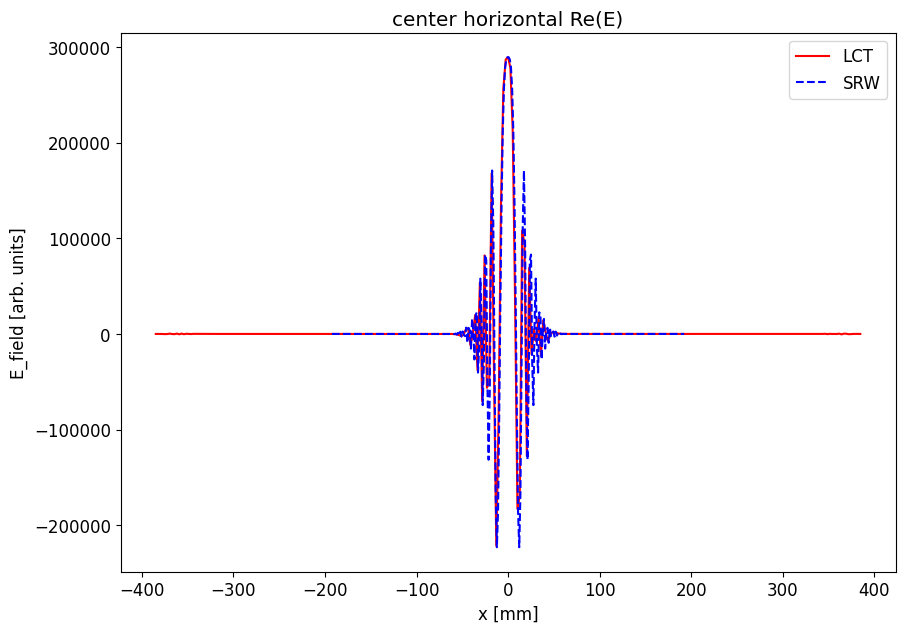

In [38]:
fig = plt.figure(figsize = (10, 7))
ax = fig.gca()

ax.plot(np.multiply(local_xv,1e3), re_slice_hor_lct, 'r-', label = r'LCT')
ax.plot(np.multiply(xvals_prop,1e3), re_slice_hor_srw, 'b--',  label = r'SRW')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
# plt.xlim(0,350)
# plt.ylim(0,100)
plt.title('center horizontal Re(E)')
plt.xlabel('x [mm]')
plt.ylabel(r'E_field [arb. units]')
plt.legend()

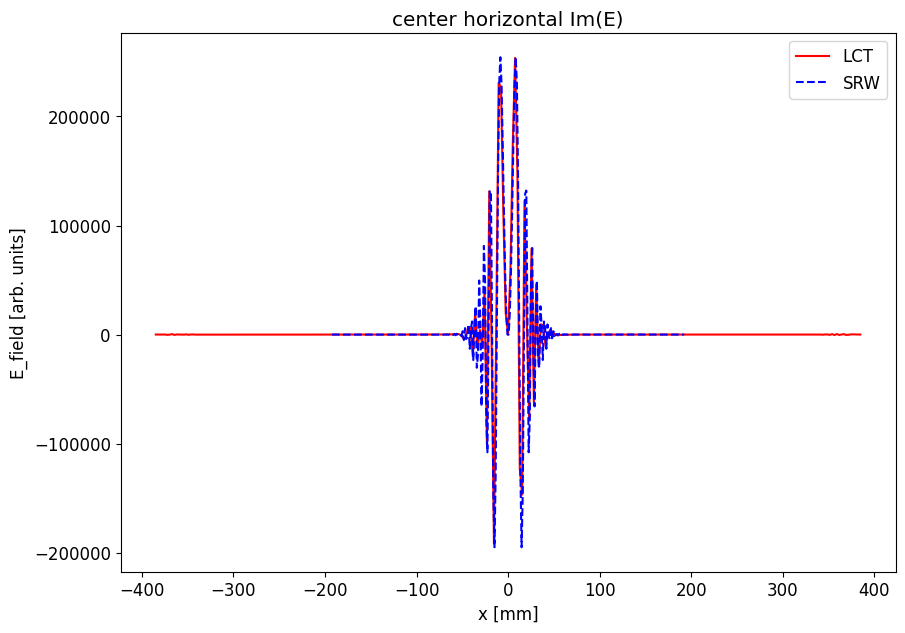

In [39]:
fig = plt.figure(figsize = (10, 7))
ax = fig.gca()

ax.plot(np.multiply(local_xv,1e3), im_slice_hor_lct, 'r-', label = r'LCT')
ax.plot(np.multiply(xvals_prop,1e3), im_slice_hor_srw, 'b--',  label = r'SRW')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
# plt.xlim(0,350)
# plt.ylim(0,100)
plt.title('center horizontal Im(E)')
plt.xlabel('x [mm]')
plt.ylabel(r'E_field [arb. units]')
plt.legend()